In [53]:
# import libraries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines
import random
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import functools
import heapq
import time

# Pre-defined classes

In [54]:
class Graph:

    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)


In [55]:
def is_in(elt, seq):
    return any(x is elt for x in seq)


def distance(a, b):
    #distance between 2 points
    xA, yA = a
    xB, yB = b
    return np.hypot((xA - xB), (yA - yB))


class Problem:
    #A problem class that has a initial and goal.

    def __init__(self, initial, goal=None):
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        raise NotImplementedError

    def result(self, state, action):
        raise NotImplementedError

    def goal_test(self, state):
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        return c + 1

    def value(self, state):
        raise NotImplementedError


class GraphProblem(Problem):

    def __init__(self, initial, goal, graph):
        super().__init__(initial, goal)
        self.graph = graph

    def actions(self, A):
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        return action

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or np.inf)

    def find_min_edge(self):
        m = np.inf
        for d in self.graph.graph_dict.values():
            local_min = min(d.values())
            m = min(m, local_min)

        return m

    def h(self, node):
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(distance(locs[node], locs[self.goal]))

            return int(distance(locs[node.state], locs[self.goal]))
        else:
            return np.inf

## Visualisation

In [56]:
def show_map(graph_data, node_colors=None):
    G = nx.Graph(graph_data['graph_dict'])
    node_colors = node_colors or graph_data['node_colors']
    node_positions = graph_data['node_positions']
    node_label_pos = graph_data['node_label_positions']
    edge_weights = graph_data['edge_weights']

    # set the size of the plot
    plt.figure(figsize=(18, 13))
    # draw the graph (both nodes and edges) with locations from romania_locations
    nx.draw(G, pos={k: node_positions[k] for k in G.nodes()},
            node_color=[node_colors[node] for node in G.nodes()], linewidths=0.3, edgecolors='k')

    # draw labels for nodes
    node_label_handles = nx.draw_networkx_labels(G, pos=node_label_pos, font_size=14)

    # add a white bounding box behind the node labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]

    # add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=14)

    # add a legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="orange", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="red", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="gray", marker='o', markersize=15, markerfacecolor="gray")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")
    black_circle = lines.Line2D([], [], color="black", marker='o', markersize=15, markerfacecolor="black")
    blue_circle = lines.Line2D([], [], color="blue", marker='o', markersize=15, markerfacecolor="blue")
    purple_circle = lines.Line2D([], [], color="purple", marker='o', markersize=15, markerfacecolor="purple")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle, green_circle, black_circle, blue_circle, purple_circle),
               ('Un-explored', 'Frontier', 'Currently Exploring', 'Sprayed', 'Final Solution', 'Object', 'Human', 'Explored'),
               numpoints=1, prop={'size': 16}, loc=(.8, .75))

    plt.show()

In [57]:
# helper functions for visualisations

def final_path_colors(initial_node_colors, problem, solution):

    # get initial node colors
    final_colors = dict(initial_node_colors)
    # color all the nodes in solution and starting node to green
    final_colors[problem.initial] = "green"
    for node in solution:
        final_colors[node] = "green"
    return final_colors


def display_visual(graph_data, user_input, algorithm=None, problem=None):
    initial_node_colors = graph_data['node_colors']
    print("1")

    def slider_callback(iteration):
        # don't show graph for the first time running the cell calling this function
        try:
            show_map(graph_data, node_colors=all_node_colors[iteration])
        except:
            pass

    def visualize_callback(visualize):
        if visualize is True:
            button.value = False
            # global all_node_colors
            while len(object_states) > 0:
                global all_node_colors
                iterations, all_node_colors, node = algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(all_node_colors[0], problem, solution))
                slider.max = len(all_node_colors) - 1

                for i in range(slider.max + 1):
                    slider.value = i
                    time.sleep(.5)
                
                problem.initial = problem.goal # go to next object
                if len(object_states) <= 0:
                    problem.goal = 'state0'
                else:
                    problem.goal = object_states[0]
                
            iterations, all_node_colors, node = algorithm(problem)
            solution = node.solution()
            all_node_colors.append(final_path_colors(all_node_colors[0], problem, solution))
            slider.max = len(all_node_colors) - 1
            
            for i in range(slider.max + 1):
                slider.value = i
                time.sleep(.5)

                

    slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
    slider_visual = widgets.interactive(slider_callback, iteration=slider)
    display(slider_visual)

    button = widgets.ToggleButton(value=False)
    button_visual = widgets.interactive(visualize_callback, visualize=button)
    display(button_visual)

## Algorithms

In [58]:
def memoize(fn, slot=None, maxsize=32):
    if slot:
        def memoized_fn(obj, *args):
            if hasattr(obj, slot):
                return getattr(obj, slot)
            else:
                val = fn(obj, *args)
                setattr(obj, slot, val)
                return val
    else:
        @functools.lru_cache(maxsize=maxsize)
        def memoized_fn(*args):
            return fn(*args)

    return memoized_fn

class Node:

    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        return [node.action for node in self.path()[1:]]

    def path(self):
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)

class PriorityQueue:

    def __init__(self, order='min', f=lambda x: x):
        self.heap = []
        if order == 'min':
            self.f = f
        elif order == 'max':  # now item with max f(x)
            self.f = lambda x: -f(x)  # will be popped first
        else:
            raise ValueError("Order must be either 'min' or 'max'.")

    def append(self, item):
        heapq.heappush(self.heap, (self.f(item), item))

    def extend(self, items):
        for item in items:
            self.append(item)

    def pop(self):
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        return len(self.heap)

    def __contains__(self, key):
        return any([item == key for _, item in self.heap])

    def __getitem__(self, key):
        for value, item in self.heap:
            if item == key:
                return value
        raise KeyError(str(key) + " is not in the priority queue")

    def __delitem__(self, key):
        try:
            del self.heap[[item == key for _, item in self.heap].index(True)]
        except ValueError:
            raise KeyError(str(key) + " is not in the priority queue")
        heapq.heapify(self.heap)


In [59]:
def best_first_graph_search_for_vis(problem, f):
    
    iterations = 0
    all_node_colors = []
    for k in problem.graph.nodes():
        if k in sprayed_object_arrays:
            node_colors[k] = 'gray'
        elif k in object_states:
            node_colors[k] = 'black'
        elif k in human_states:
            node_colors[k] = 'blue'
        else:
            node_colors[k] = 'white'
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        if node.state != 'state0':
            sprayed_object_arrays.append(node.state)
            if node.state in object_states:
                object_states.remove(node.state)
        sprayed_object_arrays.append(node.state)
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier: #frontier options
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            if node.state != 'state0':
                sprayed_object_arrays.append(node.state)
                if node.state in object_states:
                    object_states.remove(node.state)
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem): #check neighbours + does not include person in frontier
            if child.state not in explored and child not in frontier and node_colors[child.state] != "blue":
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier and node_colors[child.state] != "blue":
                incumbent = frontier[child]
                if f(child) < incumbent:
                    del frontier[child]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    
        node_colors[node.state] = "purple"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

# A* Search
def astar_search_graph(problem, h=None):
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, 
                                                                lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)


# Get paths 

In [60]:
# find the adjacent states of current states
def adjacent_states(cur_state, all_states_locs): # find possible states near the current state.
    adjacent_states_locs = []
    relative_states_location = [[-1,0],[1,0],[0,1],[0,-1]] # the possible locations according to the current location
    for i in relative_states_location:
        if all_states_locs.count([cur_state[0]+i[0],cur_state[1]+i[1]]) > 0:
            adjacent_states_locs.append([cur_state[0]+i[0],cur_state[1]+i[1]])
    return cur_state, adjacent_states_locs


# generate path information to draw graph
def generate_paths(all_states_locs):  
    # print(f"all states locs: {all_states_locs}")
    paths = {}
    for state_loc in all_states_locs:
        curr_state, adjacent_states_locs = adjacent_states(state_loc, all_states_locs)
        neighbor_states_dict = {}
        for adjacent_state_loc in adjacent_states_locs:
            neighbor_states_dict[f'state{all_states_locs.index(adjacent_state_loc)}'] = 1 # {'state1 : 0'}
        paths['state{}'.format(all_states_locs.index(state_loc))] = neighbor_states_dict # {'state1':  {'state2': 1}}
    return paths

# give all locations a name, i.e., 'state1' and store the names and locations in a dictionary
def generate_states(all_states_locs): 
    locations_dict = {}
    scale = 50  # control the map size
    for state_loc in all_states_locs:
        locations_dict['state{}'.format(all_states_locs.index(state_loc))] = (state_loc[0]*scale,state_loc[1]*scale)
    return locations_dict

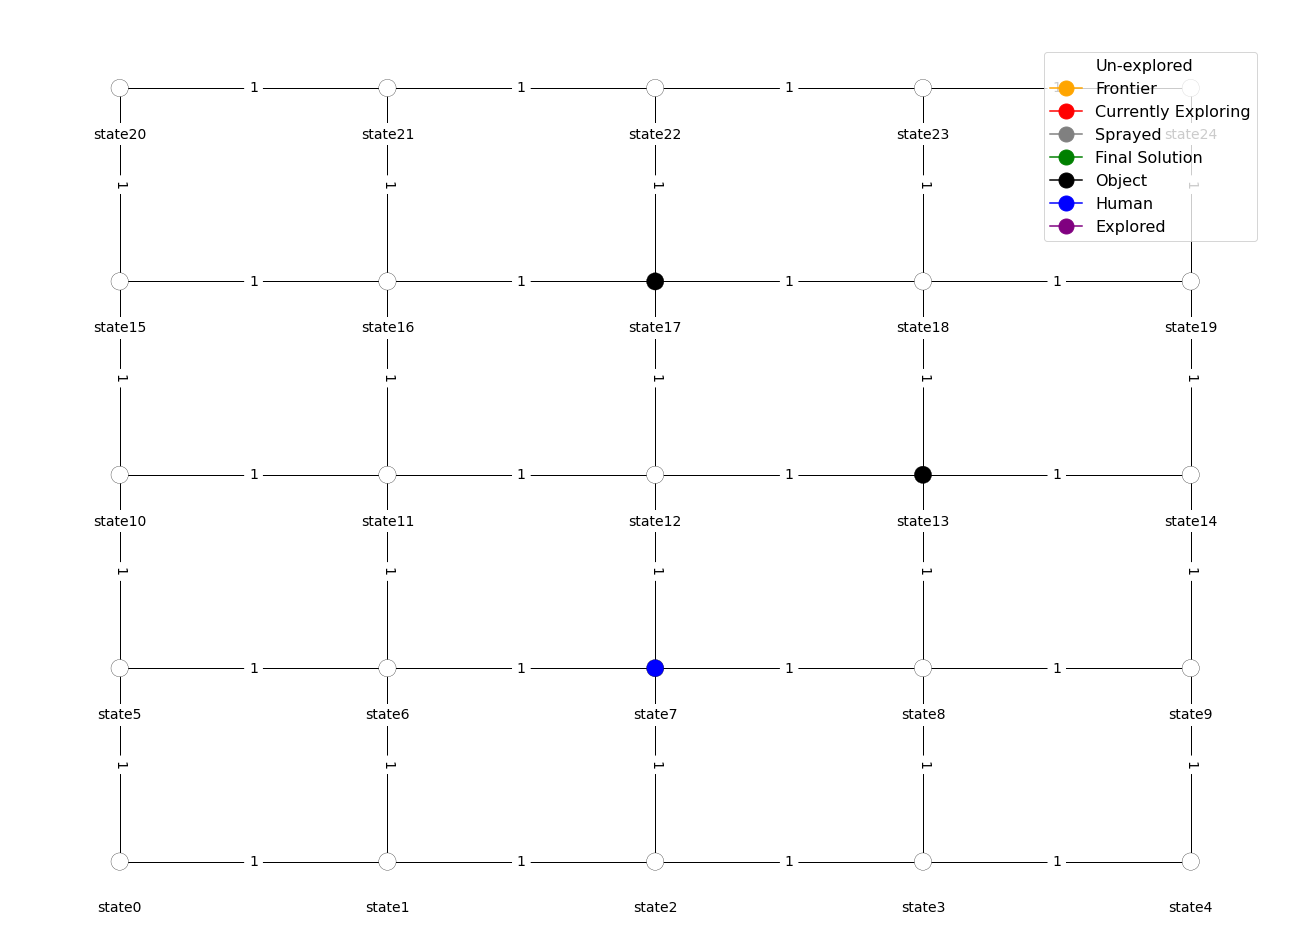

In [61]:
# define parameters for map construction
map_size_rows = 5  # the map size in vertical 
map_size_columns = 5  # the map size in horizon 
all_states_locs = []  # create a dictionary to store states' coordinates
object_states_locs = []  # create a dictionary to store coordinates of object states
human_states_locs = []
num_object_states = random.randint(1, (map_size_columns*map_size_rows)-1)  # define the number of objects
num_human_states = 1 # define the number of humans
sprayed_object_arrays = []

# define the size of the map
for i in range(0,map_size_rows):
    for j in range(0,map_size_columns):
        all_states_locs.append([j,i]) 

# Generate the graph
vacuum_n_n_map = Graph(generate_paths(all_states_locs))
vacuum_n_n_map.locations = generate_states(all_states_locs)

# randomly pick object states
object_states = random.sample(vacuum_n_n_map.nodes(), num_object_states)
if 'state0' in object_states:
    object_states.remove('state0')
#randomly pick human states
no_object_map = [item for item in vacuum_n_n_map.nodes() if item not in object_states] #all nodes that are not objects
if 'state0' in no_object_map:
    no_object_map.remove('state0')
human_states = random.sample(no_object_map, num_human_states)

# define node_color
node_colors = {}
for node in vacuum_n_n_map.locations.keys():
    if node in sprayed_object_arrays:
        node_colors[node] = 'gray'
    elif node in object_states:
        node_colors[node] = 'black'
    elif node in human_states:
        node_colors[node] = 'blue'
    else:
        node_colors[node] = 'white'

# set the position of labels
node_positions = vacuum_n_n_map.locations
node_label_pos = { k:[v[0],v[1]-12]  for k,v in vacuum_n_n_map.locations.items() }

# set weight for each edge
edge_weights = {(k, k2) : v2 for k, v in vacuum_n_n_map.graph_dict.items() for k2, v2 in v.items()}

vacuum_n_n_graph_data = {  'graph_dict' : vacuum_n_n_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                        'edge_weights': edge_weights
                    }

show_map(vacuum_n_n_graph_data)

In [62]:
vacuum_n_n_map.graph_dict.items() #dictioniary displaying all states and their neighbours

dict_items([('state0', {'state1': 1, 'state5': 1}), ('state1', {'state0': 1, 'state2': 1, 'state6': 1}), ('state2', {'state1': 1, 'state3': 1, 'state7': 1}), ('state3', {'state2': 1, 'state4': 1, 'state8': 1}), ('state4', {'state3': 1, 'state9': 1}), ('state5', {'state6': 1, 'state10': 1, 'state0': 1}), ('state6', {'state5': 1, 'state7': 1, 'state11': 1, 'state1': 1}), ('state7', {'state6': 1, 'state8': 1, 'state12': 1, 'state2': 1}), ('state8', {'state7': 1, 'state9': 1, 'state13': 1, 'state3': 1}), ('state9', {'state8': 1, 'state14': 1, 'state4': 1}), ('state10', {'state11': 1, 'state15': 1, 'state5': 1}), ('state11', {'state10': 1, 'state12': 1, 'state16': 1, 'state6': 1}), ('state12', {'state11': 1, 'state13': 1, 'state17': 1, 'state7': 1}), ('state13', {'state12': 1, 'state14': 1, 'state18': 1, 'state8': 1}), ('state14', {'state13': 1, 'state19': 1, 'state9': 1}), ('state15', {'state16': 1, 'state20': 1, 'state10': 1}), ('state16', {'state15': 1, 'state17': 1, 'state21': 1, 'state

In [63]:
the_problem = GraphProblem('state0', object_states[0], vacuum_n_n_map)

display_visual(vacuum_n_n_graph_data, user_input=False,
                algorithm=astar_search_graph,
                problem=the_problem)


1


interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

In [64]:
object_states #print object states

['state17', 'state13']

In [65]:
human_states #print person states

['state7']